In [8]:
import evaluation_helper
import numpy as np
import sklearn.metrics as metrics
import re
import plotly.express as px
import os
import pandas as pd

In [9]:
output_files = set(os.listdir("output/"))

In [10]:
results = {}
all_models = set()

gad_7_multilingual.csv
04_mpnet
05_google_vertex_ai_gecko
01_harmony
02_ada2
07_harmony_distiluse
03_ada3
06_google_vertex_ai_gecko_multilingual
08_harmony_xlm
00_bag_of_words


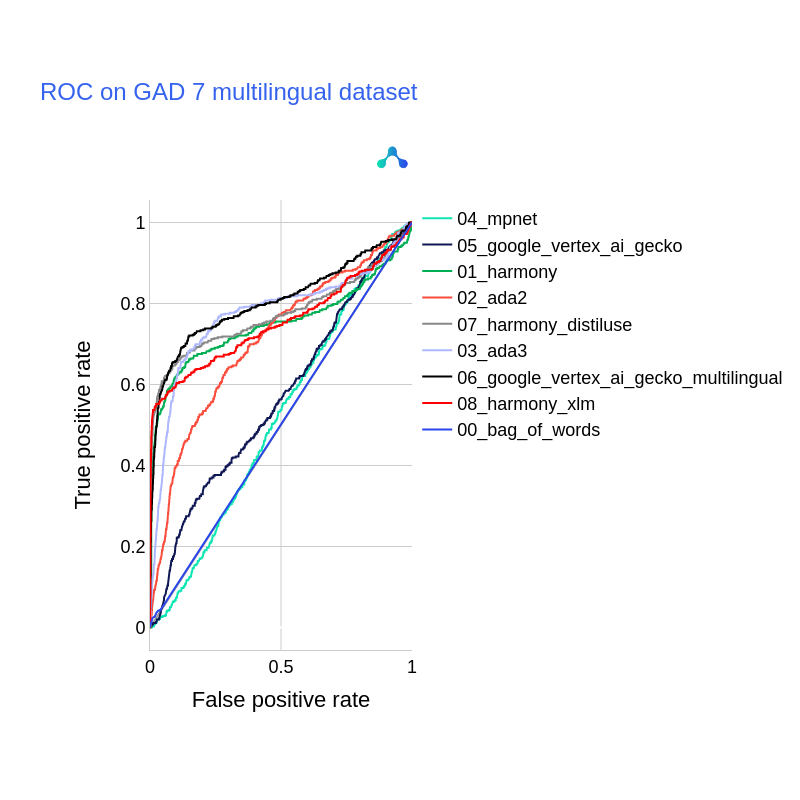

mcelroy_cosine_correlation.csv
04_mpnet
03_ada3
00_bag_of_words
02_ada2
08_harmony_xlm
06_google_vertex_ai_gecko_multilingual
05_google_vertex_ai_gecko
07_harmony_distiluse
01_harmony
mcelroy_childhood.csv
07_harmony_distiluse
01_harmony
05_google_vertex_ai_gecko
02_ada2
08_harmony_xlm
03_ada3
00_bag_of_words
06_google_vertex_ai_gecko_multilingual
04_mpnet


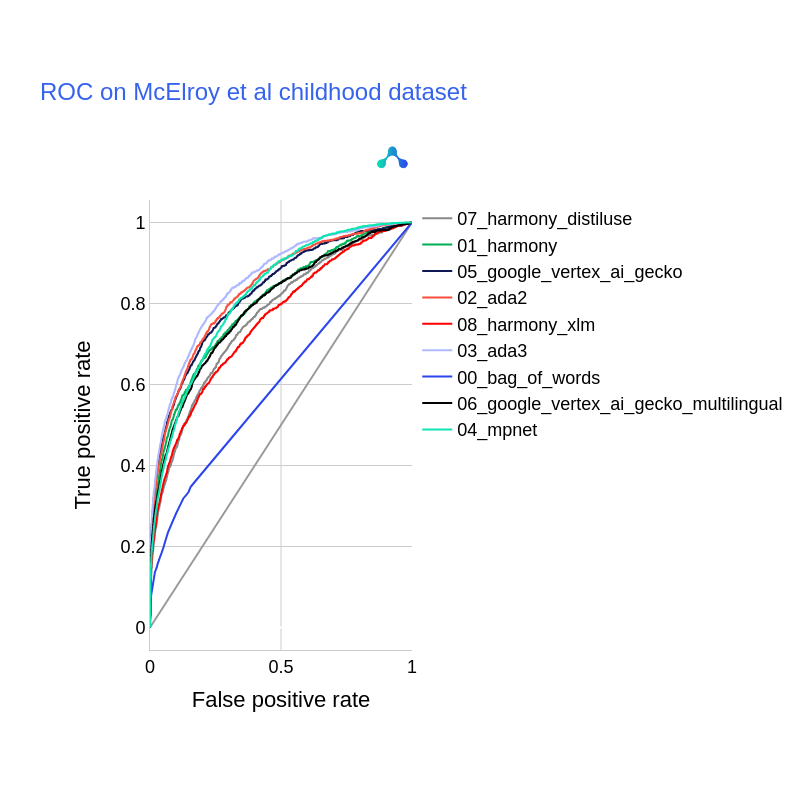

mcelroy_adulthood.csv
03_ada3
05_google_vertex_ai_gecko
04_mpnet
00_bag_of_words
08_harmony_xlm
02_ada2
07_harmony_distiluse
01_harmony
06_google_vertex_ai_gecko_multilingual


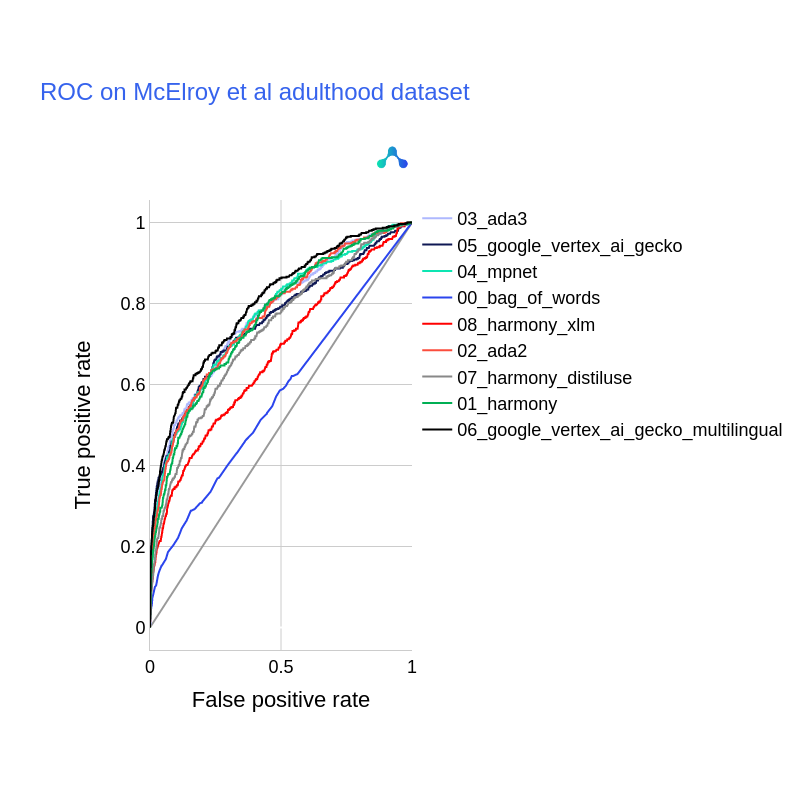

In [12]:
for input_file, data in evaluation_helper.get_datasets():
    print(input_file)
    
    results_this_file = {}
    
    input_file_pretty = re.sub(r'.csv', '', re.sub(r'_', ' ', input_file))
    input_file_pretty = re.sub(r'gad', 'GAD', input_file_pretty)
    input_file_pretty = re.sub(r'mcelroy', 'McElroy et al', input_file_pretty)
    
    results[input_file_pretty] = results_this_file    
    
    diagonal_range = np.arange(0,1.01,0.1)

    if "cosine_correlation" not in input_file:
        fig = px.line(x=diagonal_range, y=diagonal_range,
                        title=f"ROC on {input_file_pretty} dataset")
        fig.update_traces(line_color="#999999")
    
    
    for output_file in output_files:
        if input_file in output_file:
            model_name = re.sub(r'_model_on.+', '', output_file)
            print (model_name)
            all_models.add(model_name)
            model_number = int(model_name[:2])
            
            
            
            output_data = pd.read_csv(f"output/{output_file}", sep="\t")
            data["y_pred"] = output_data["y_pred"]
            
            
            corr_matrix = np.corrcoef(data.y, data.y_pred)
            corr = corr_matrix[0,1]
            R_sq = corr**2
            
            roc_auc = 0

            if "cosine_correlation" not in input_file:
                fpr, tpr, threshold = metrics.roc_curve(data.y, data.y_pred)
                roc_auc = metrics.auc(fpr, tpr)
                
                colours = {0:"#2b45ed",
                       1:"#00af54",
                          2:"#fb4d3d",
                          3:"#aeb8fe",
                           4:"#0de5b2",
                          
                          5:"#0f1854",
                           6:"#000000",
                           7:"#888888",
                            8:"#ff0000",
                          }
                
                fig.add_scatter(x=fpr, y=tpr, mode="lines", name=model_name, line=dict(color=colours[model_number])) 
                
                
            results_this_file[model_name] = {"correlation": corr, "R²": R_sq, "AUC": roc_auc}

    if "cosine_correlation" not in input_file:
        fig.update_xaxes(showline=True, linewidth=1, linecolor='#cccccc', gridcolor='#cccccc')
        fig.update_yaxes(showline=True, linewidth=1, linecolor='#cccccc', gridcolor='#cccccc')
        
        fig.add_layout_image(
                        dict(
                            source="https://raw.githubusercontent.com/harmonydata/brand/main/logomark/PNG/Logomark-04.png",
                            xref="paper", yref="paper",
                            x=1.05, y=1.05,
                            sizex=0.25, sizey=0.25,
                            xanchor="right", yanchor="bottom"
                        )
                    )

        fig.update_layout(
            title_font_family="Helvetica",
            xaxis_title="False positive rate",
            yaxis_title="True positive rate",
            font=dict(
                family="Helvetica",
                size=18,
                color="rgb(0,0,0)"
            ),
            title_font=dict(
                family="Helvetica",
                size=24,
                color="rgb(54,99,237)"
            ),
            paper_bgcolor='rgb(255,255,255)',
            plot_bgcolor='rgb(255,255,255)',
            width=800,
            height=800,
            margin=dict(l=150, r=100, t=200, b=150),
        )

        fig.show(renderer="png")

In [13]:
import json
print (json.dumps(results, indent=4))

{
    "GAD 7 multilingual": {
        "04_mpnet": {
            "correlation": -0.002009911362750739,
            "R\u00b2": 4.039743686114532e-06,
            "AUC": 0.5154119796976939
        },
        "05_google_vertex_ai_gecko": {
            "correlation": 0.0817147148016897,
            "R\u00b2": 0.006677294615121485,
            "AUC": 0.5645997342425914
        },
        "01_harmony": {
            "correlation": 0.3510517581295848,
            "R\u00b2": 0.12323733688587249,
            "AUC": 0.7499784106926963
        },
        "02_ada2": {
            "correlation": 0.28639052380189794,
            "R\u00b2": 0.08201953212352547,
            "AUC": 0.7086488157916729
        },
        "07_harmony_distiluse": {
            "correlation": 0.47239108235109273,
            "R\u00b2": 0.22315333468483686,
            "AUC": 0.7747427390284534
        },
        "03_ada3": {
            "correlation": 0.3804838083021006,
            "R\u00b2": 0.14476792838006963,
          

In [14]:
with pd.ExcelWriter('output.xlsx') as writer:  
    for m in ["correlation", "R²", "AUC"]:
        df_results = pd.DataFrame()
        df_results["dataset"] = sorted(results)
        for model_name in sorted(all_models):
            df_results[model_name] = df_results["dataset"].apply(lambda dataset_name : results[dataset_name][model_name][m])
        df_results.to_excel(writer, sheet_name=m, index=False)

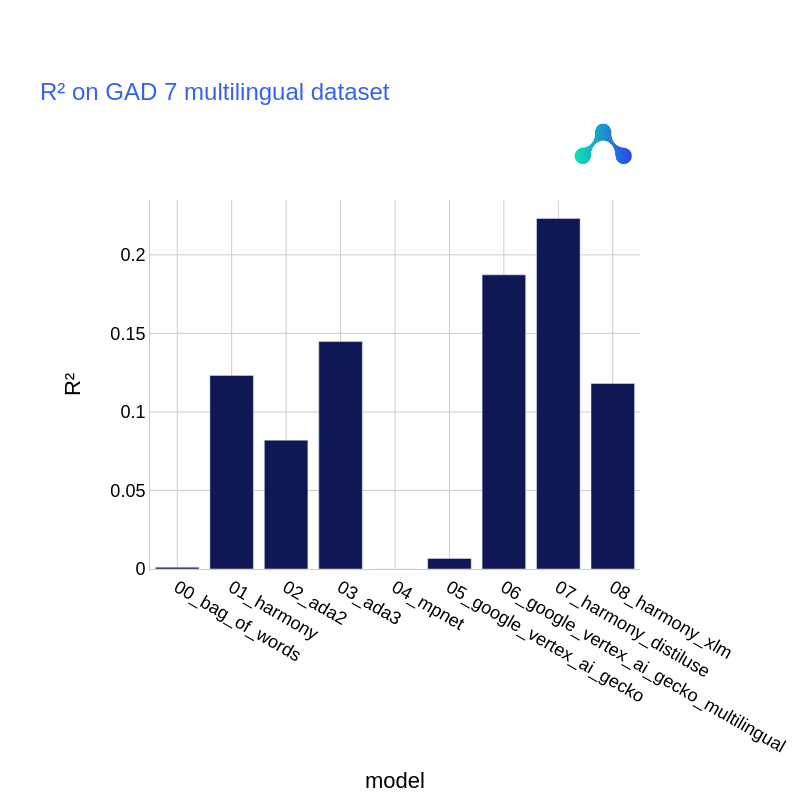

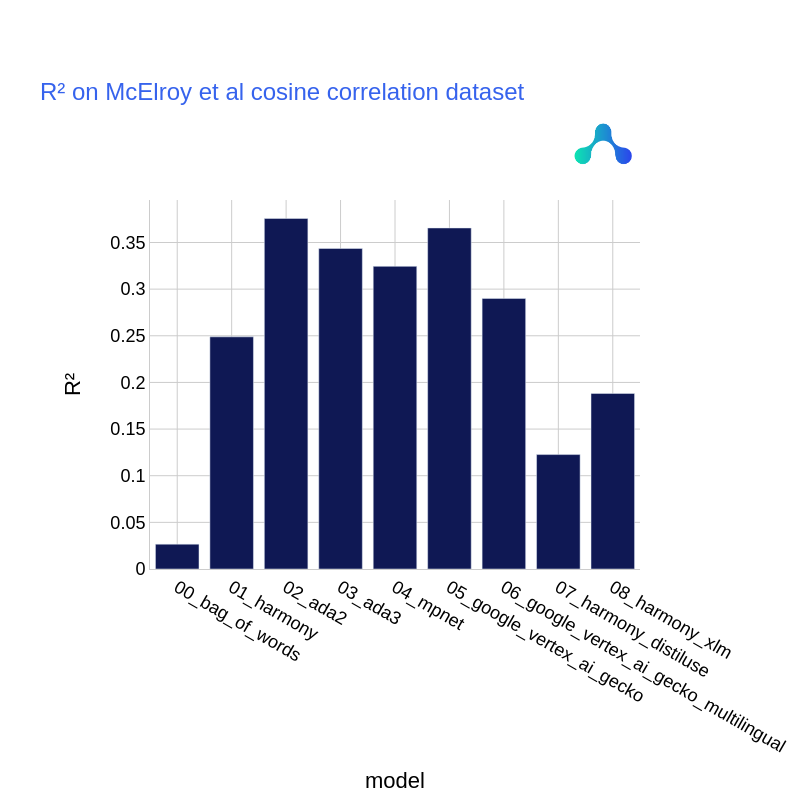

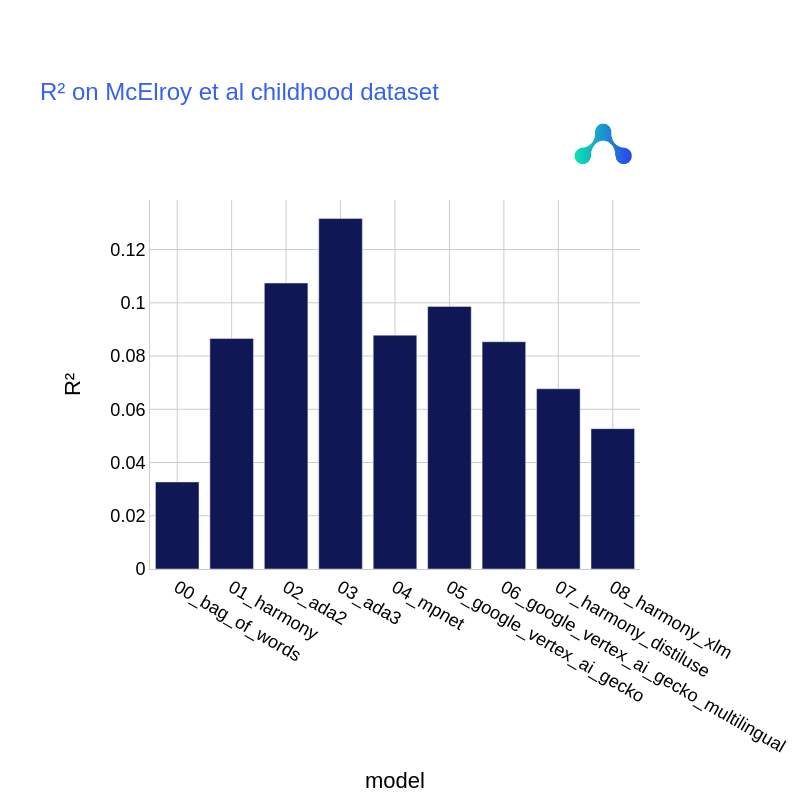

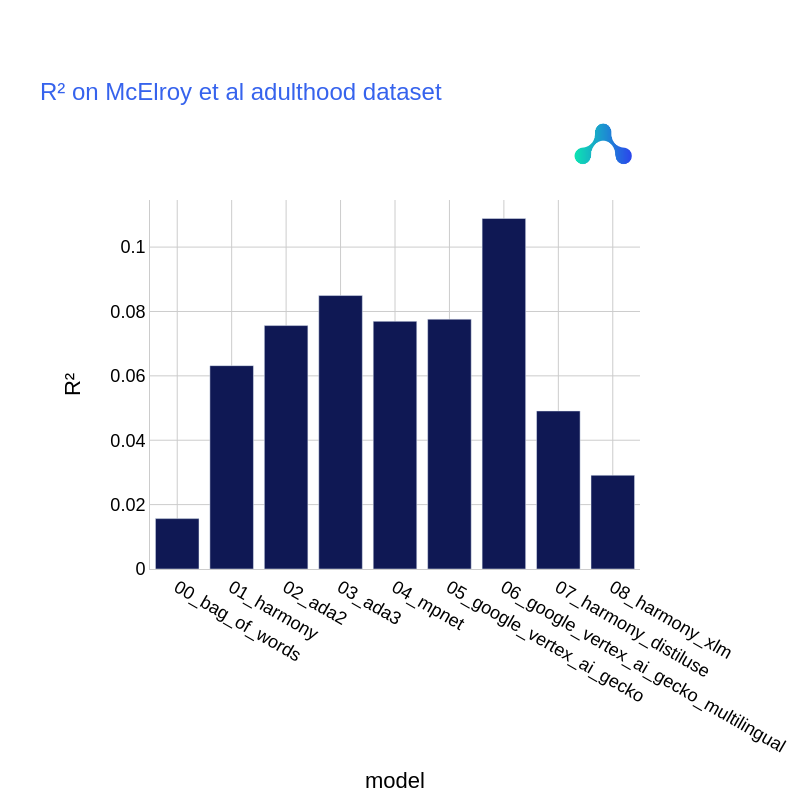

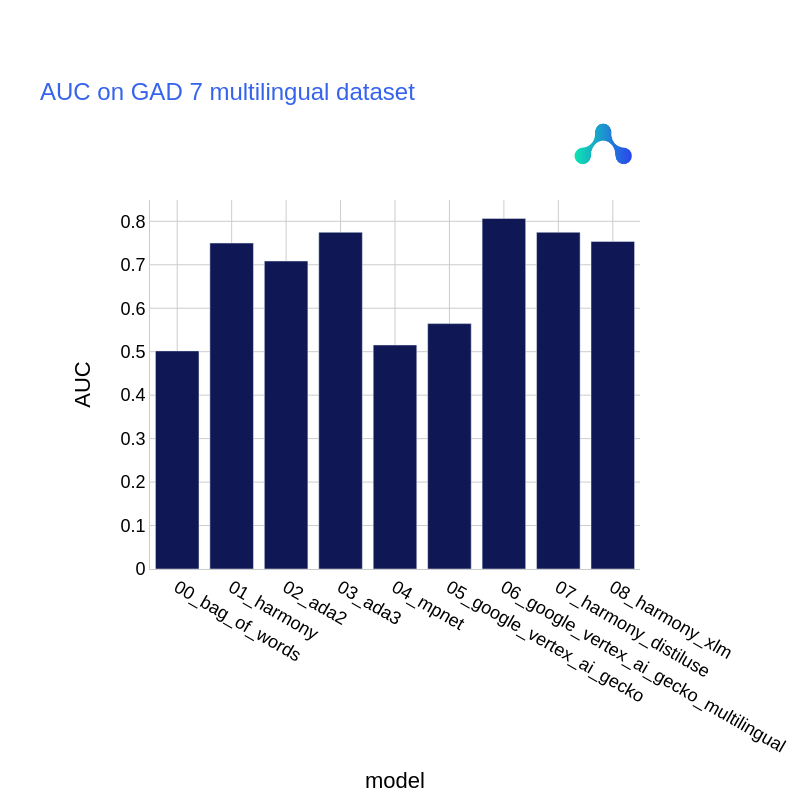

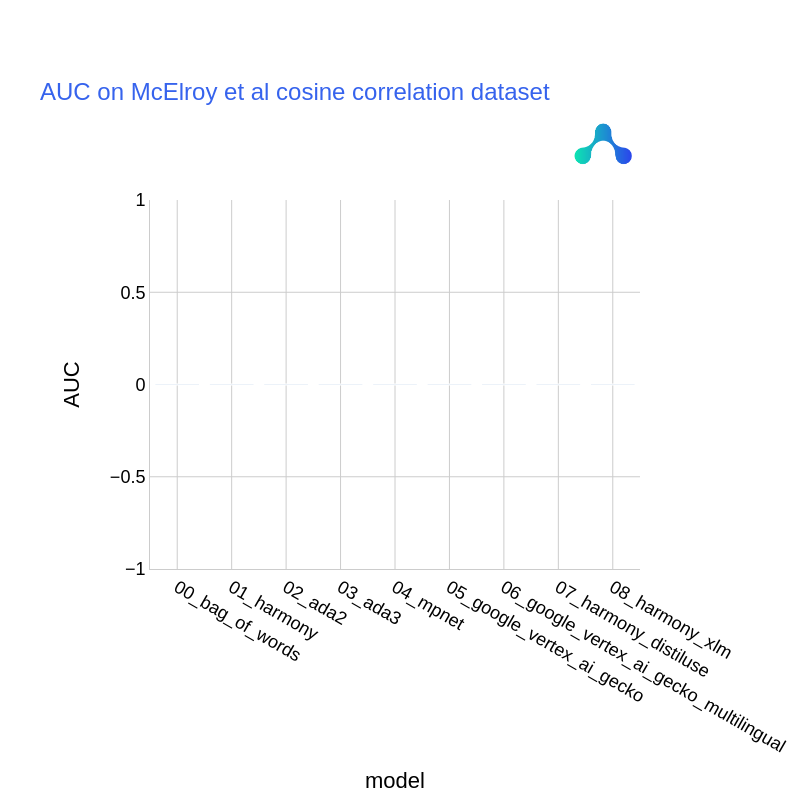

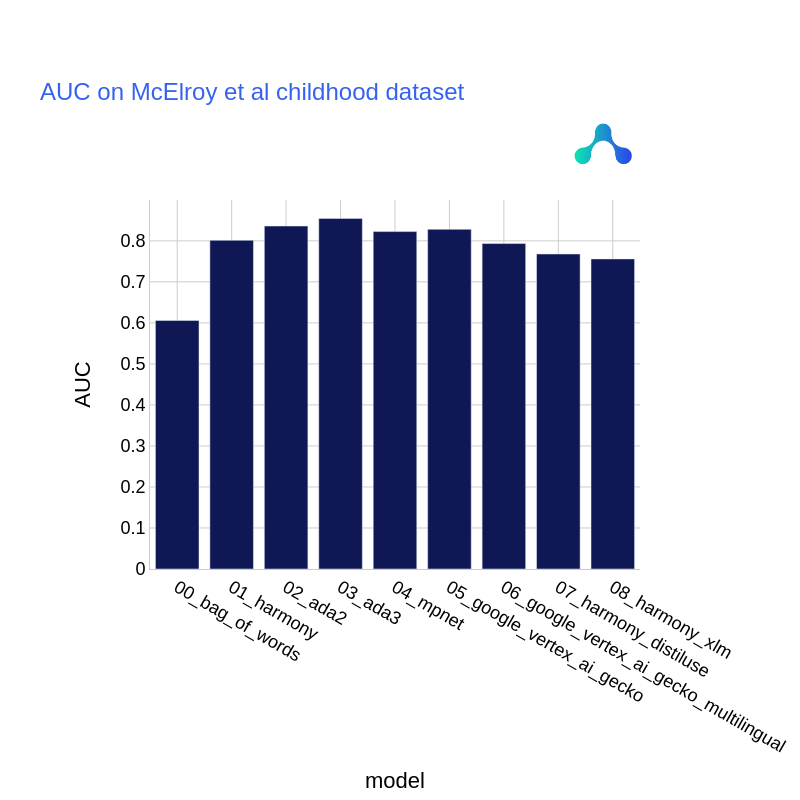

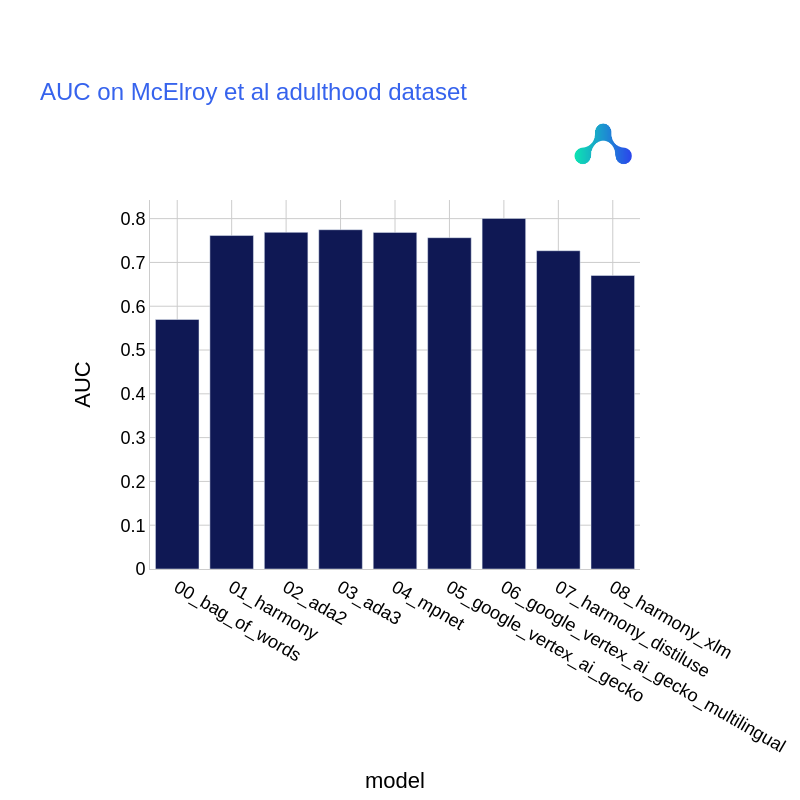

In [15]:
for m in ["R²", "AUC"]:
    for dataset, results_per_model in results.items():
        df = pd.DataFrame()
        df['model'] = sorted(results_per_model)
        df[m] = df['model'].apply(lambda model_name : results_per_model[model_name][m])
        
        fig = px.bar(data_frame=df, x="model", y=m, title=f"{m} on {dataset} dataset",
                   color_discrete_sequence=['#0f1854']
                  )
        
        fig.update_xaxes(showline=True, linewidth=1, linecolor='#cccccc', gridcolor='#cccccc')
        fig.update_yaxes(showline=True, linewidth=1, linecolor='#cccccc', gridcolor='#cccccc')
        
        fig.add_layout_image(
                        dict(
                            source="https://raw.githubusercontent.com/harmonydata/brand/main/logomark/PNG/Logomark-04.png",
                            xref="paper", yref="paper",
                            x=1.05, y=1.05,
                            sizex=0.25, sizey=0.25,
                            xanchor="right", yanchor="bottom"
                        )
                    )

        fig.update_layout(
            title_font_family="Helvetica",
            font=dict(
                family="Helvetica",
                size=18,
                color="rgb(0,0,0)"
            ),
            title_font=dict(
                family="Helvetica",
                size=24,
                color="rgb(54,99,237)"
            ),
            paper_bgcolor='rgb(255,255,255)',
            plot_bgcolor='rgb(255,255,255)',
            width=800,
            height=800,
            margin=dict(l=150, r=100, t=200, b=150),
        )

        fig.show(renderer="png")